In [ ]:
!pip install super_gradients

In [1]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

net = models.get(Models.YOLO_NAS_L, pretrained_weights="coco")

The console stream is logged into /root/sg_logs/console.log


[2023-05-31 10:55:27] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-31 10:55:38] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-31 10:55:38] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-31 10:55:38] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-31 10:55:38] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-05-31 10:55:40] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with thes

  0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


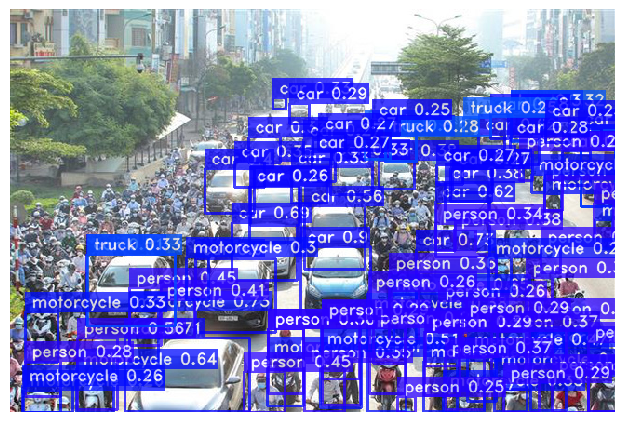

In [2]:
prediction = net.predict("https://vtv1.mediacdn.vn/thumb_w/650/2021/9/21/vnapotalgiaothonghanoidongductrongngaydauhetthoithoigiangiancachxahoitheochithi165677843-16321890520351645599985.jpeg")
prediction.show()

In [3]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

In [4]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size, 
            unit='iB', 
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')
        
download_file(
    'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
    'hituav-a-highaltitude-infrared-thermal-dataset.zip'
)

  0%|          | 0.00/200M [00:00<?, ?iB/s]

In [5]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('hituav-a-highaltitude-infrared-thermal-dataset.zip')

In [6]:
ROOT_DIR = '/content/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [7]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}
dataset_params

{'data_dir': '/content/hit-uav',
 'train_images_dir': 'images/train',
 'train_labels_dir': 'labels/train',
 'val_images_dir': 'images/val',
 'val_labels_dir': 'labels/val',
 'test_images_dir': 'images/test',
 'test_labels_dir': 'labels/test',
 'classes': ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']}

In [8]:
# Global parameters.
EPOCHS = 5
BATCH_SIZE = 16

**Visualize Ground Truth Images**

In [14]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [15]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax


def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image, 
            p1, p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw/3.5, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image


# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
        
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

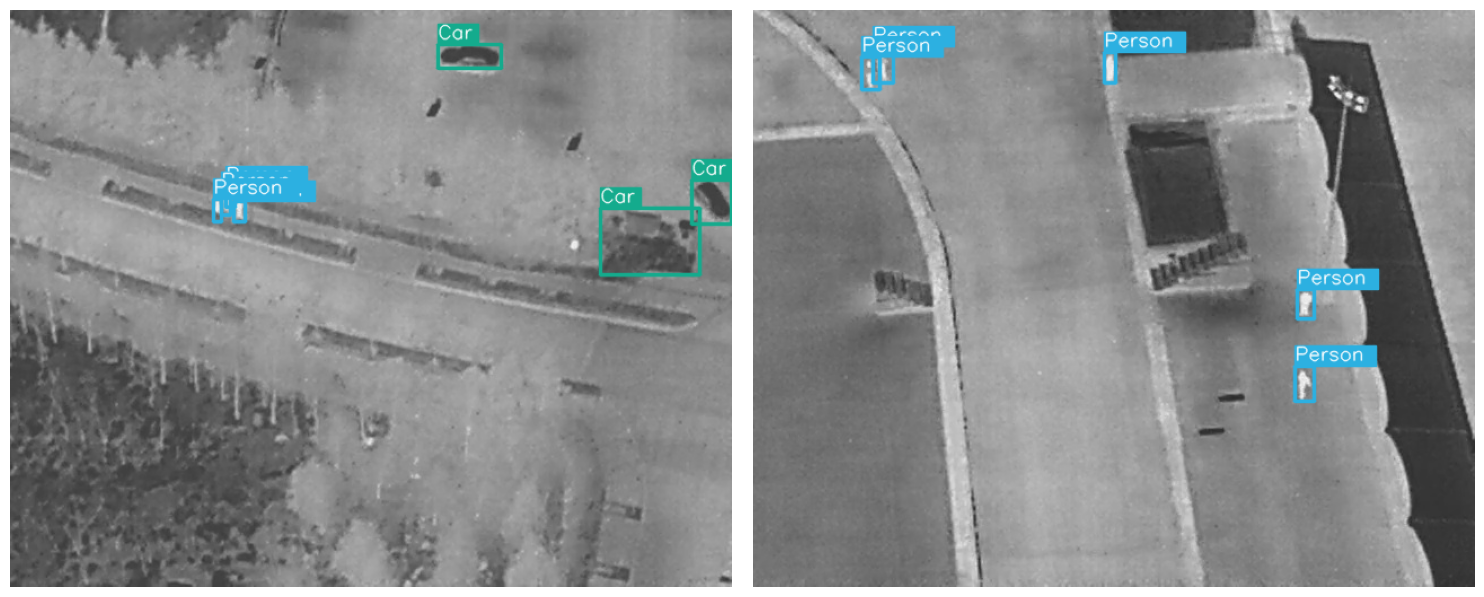

In [17]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=2,
)

In [9]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        "shuffle": True
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        "shuffle": True
    }
)

Extracted all


Caching annotations: 100%|██████████| 2008/2008 [00:00<00:00, 3043.37it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Caching annotations: 100%|██████████| 287/287 [00:00<00:00, 4799.45it/s]


In [ ]:
train_data.dataset.transforms

In [ ]:
train_data.dataset.transforms[0]

In [ ]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

In [ ]:
train_data.dataset.transforms

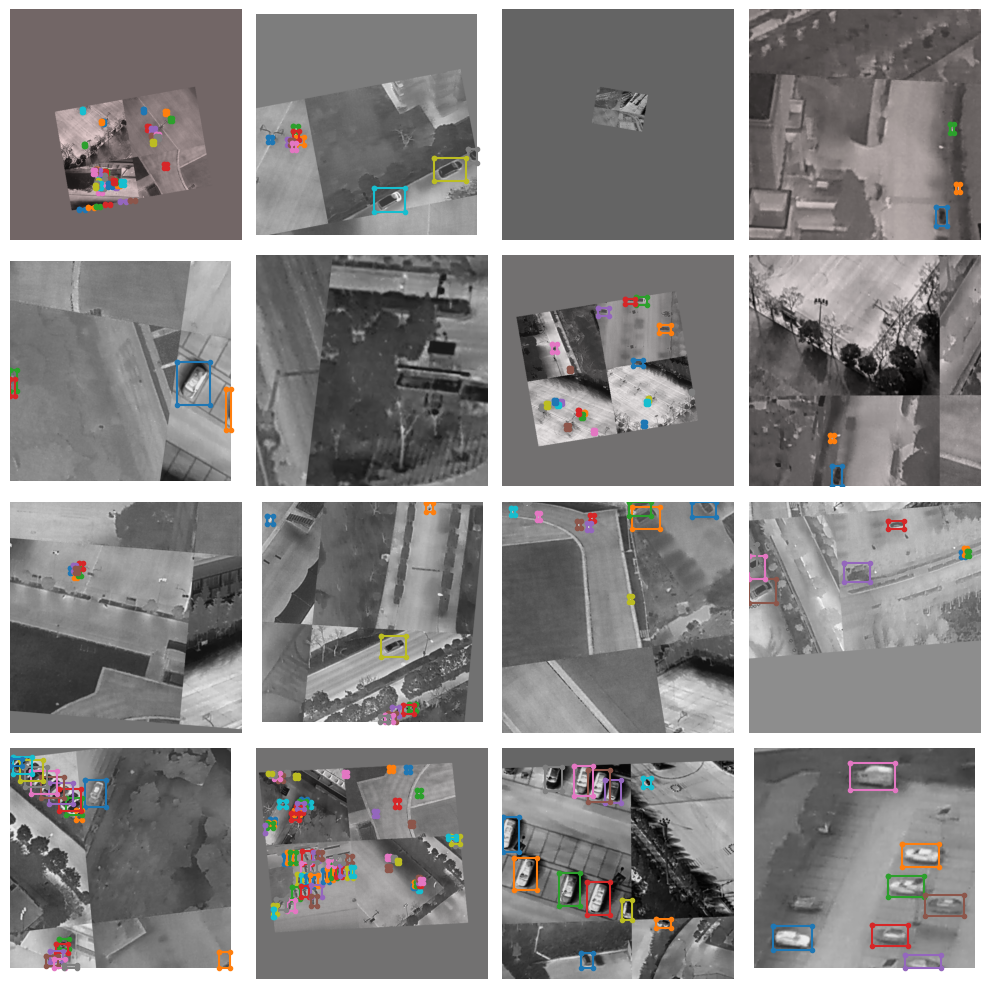

In [28]:
# We visualize the images with augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

In [10]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [11]:
# models_to_train = [
#     'yolo_nas_s',
#     'yolo_nas_m',
#     'yolo_nas_l'
# ]

models_to_train = [
    'yolo_nas_s',
]
CHECKPOINT_DIR = 'checkpoints'

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )

    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

In [13]:
import torch
import glob
import cv2
import matplotlib.pyplot as plt
import random
import os

from super_gradients.training import models
from tqdm.auto import tqdm

In [14]:
os.makedirs('inference_results/images/', exist_ok=True)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [15]:
model = models.get(
    model_name='yolo_nas_s',
    checkpoint_path='checkpoints/yolo_nas_s/ckpt_best.pth',
    num_classes=5
).to(device)

[2023-05-31 11:16:43] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/yolo_nas_s/ckpt_best.pth EMA checkpoint.


In [18]:
out = model.predict("/content/hit-uav/images/test/0_100_30_0_03307.jpg")
out.save('inference_results/images')

In [ ]:
ROOT_TEST = 'hit-uav/images/test/'
all_images = os.listdir(ROOT_TEST)
all_images

In [19]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg', 
        os.path.join('inference_results/images/', image)
    )

  0%|          | 0/571 [00:00<?, ?it/s]

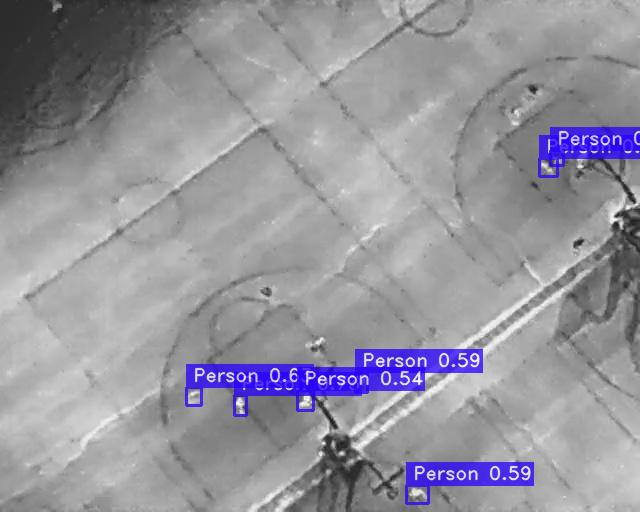

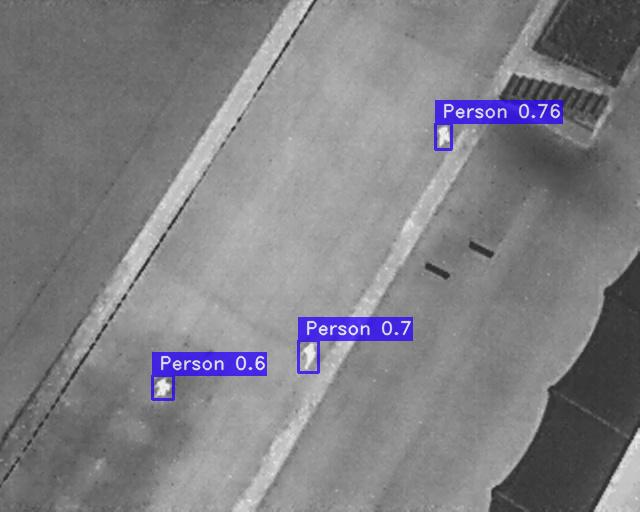

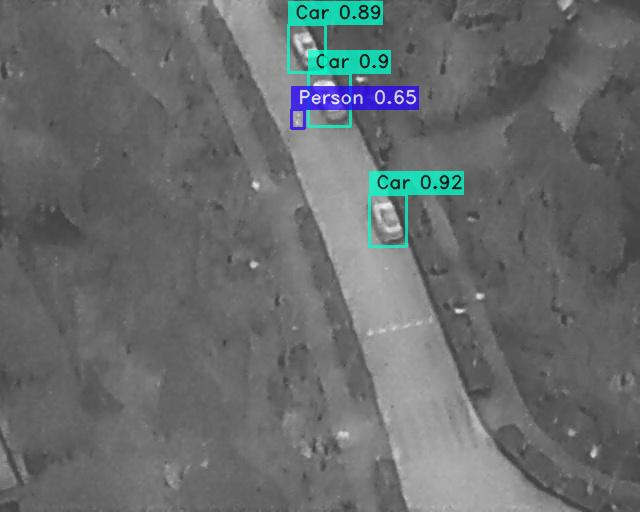

inference_results/images/0_70_70_0_01998.jpg



inference_results/images/1_60_70_0_00573.jpg



inference_results/images/0_120_50_0_09536.jpg





In [20]:
# display test inference result images
import glob
from IPython.display import Image, display

i = 0
limit = 3 # max images to print
for imageName in glob.glob('inference_results/images/*.jpg'): #assuming JPG
    if i < limit:
        print(imageName)
        display(Image(filename=imageName))
        print("\n\n")
    i = i + 1